In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import time
from rank_bm25 import BM25L
import pickle


# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

### Load ground truth dataset

In [2]:
matches_training_df = pd.read_parquet('data/matches_training.parquet')
offers_testing_df = pd.read_parquet('data/offers_test.parquet')

### Run utils script
Loads functions for exploration, metrics, and image retrieval

In [3]:
#Explore matches, metrics
%run ./utils/utils.py

#use get_img(url)
%run ./utils/img-manager.py

## Brand analysis

### Brand text processing
- Lower case text
- Accented vowels removal `è, é, ... -> e`
- Stop words removal (German)

In [4]:
stop_word_list = []

with open('processing/text_processing/german_stopwords.txt', "r") as f:
    stop_word_list = f.read().split()

### Class for applying general purpose text transformations

In [5]:
class TextTransformer:
    def processed_text(self, text):
        if text is None:
            return ''
        #lower
        processed = text.lower()
        #remove accents
        processed = self.simplify(processed)
        #remove special characters
        processed = ''.join(c if c.isalnum() or c == ' ' else ' ' for c in processed)
        #remove unnecessary double spaces
        processed = re.sub(' +', ' ', processed)
        #strip
        processed = processed.strip()
        #remove stopwords
        processed_list = [word for word in processed.split() if word not in stop_word_list]
        return ' '.join(processed_list)
    
    def simplify(self, text):
        try:
            text = unicode(text, 'utf-8')
        except NameError:
            pass
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        return str(text)

### Read files for german colors transformation

In [6]:
with open('processing/color_processing/kfix_de.txt') as f:
    color_kfix_list = f.read().splitlines() 

with open('processing/color_processing/primary_colors_de.txt') as f:
    primary_colors = f.read().splitlines() 
color_matches = {}
with open('processing/color_processing/color_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        color_matches[key] = val

### Read files for german titles transformation

In [7]:
with open('processing/title_processing/kfix_de.txt') as f:
    clothes_kfix_list = f.read().splitlines() 

with open('processing/title_processing/primary_clothes_de.txt') as f:
    primary_clothes = f.read().splitlines() 
clothes_matches = {}
with open('processing/title_processing/clothes_matches_de.txt') as f:
    for line in f:
        (key, val) = line.split(':')
        val = val.strip()
        clothes_matches[key] = val

### Class for applying specific purpose text transformations
for title and color features

In [8]:
class SpecificTrasformer(TextTransformer):
    def __init__(self,
                 kfix_list, 
                 matches, 
                 primary):
        self.kfix_list = kfix_list
        self.matches = matches
        self.primary = primary
    def separe_word(self, text, word):
        i = text.find(word)
        text = text[:i] + ' ' + text[i:] if i != -1 else text
        return text[:i+len(word)+1] + ' ' + text[i+len(word)+1:] if i != -1 else text
    def separe_words(self, text):
        for color in self.primary:
            text = self.separe_word(text, color)
        return text
    def replace_words(self, text):
        for k, v in self.matches.items():
            text = text.replace(k, v)
        return text
    def remove_kfix(self, text):
        for suffix in self.kfix_list:
            text = text.replace(suffix, '')
        return text
    
    def processed_text(self, text):
        splitted = super().processed_text(text).split()
        #1 transform matches
        splitted = [self.replace_words(text) for text in splitted]
        #2 suffix removal
        splitted = [self.remove_kfix(text) for text in splitted]
        #separate primary colors
        splitted = [self.separe_words(term) for term in splitted]
        return re.sub(' +', ' ', ' '.join(splitted).strip())

### Instance of text transformers

In [9]:
tt = TextTransformer()
ct = SpecificTrasformer(color_kfix_list, color_matches, primary_colors)
titlet = SpecificTrasformer(clothes_kfix_list, clothes_matches, primary_clothes)

### Class for brand management

In [10]:
class Brand:
    def __init__(self, name, parent=None, child=list()):
        self.name = name
        self.parent = parent
        self.child = child

In [11]:
class BrandCollection:
    def __init__(self, brand_list):
        self.brands = {}
        self.brand_family = {}
        self.manual_matches = {}
        #brand_list = [TextTransformer(x).processed_text() for x in brand_list]
        brand_list.sort()
        for el in brand_list:
            self.process_brand(Brand(el))
    
    def process_brand(self, brand):
        if brand.name not in self.brands:
            parent_likelyhood = 0
            likely_parent = None
            for k in self.brands.keys():
                comp = self.brands[k]
                l_comp = self.listify(comp, brand)
                l_brand = self.listify(brand, comp)
                calc_likelyhood = self.parent_likelyhood(l_comp, l_brand)
                if calc_likelyhood > parent_likelyhood:
                    parent_likelyhood = calc_likelyhood
                    brand.parent = comp
                    likely_parent = self.brands[comp.name]
            self.brands[brand.name] = brand
            self.brand_family[brand] = []
            if likely_parent is not None:
                self.brand_family[likely_parent].append(brand)
    
    def listify(self, brand, to_compare):
        l_brand = brand.name.split()
        l_comp = to_compare.name.split()
        max_len = len(l_brand) if len(l_brand) > len(l_comp) else len(l_comp)
        if len(l_brand) == max_len:
            return l_brand
        for i in range(max_len - len(l_brand)):
            l_brand += ['']
        return l_brand
    
    def parent_likelyhood(self, l_comp, l_brand):
        likelyhood = 0
        #check longest matching n-gram, does not check for combinations
        for i in range(len(l_comp)):
            if l_comp[i] == l_brand[i]:
                likelyhood += 1
            else:
                return likelyhood
        return likelyhood
    
    def similarity(self, str_1, str_2):
        return textdistance.levenshtein.normalized_similarity(str_1, str_2)
    
    def get_match(self, brand_query):
        brand_to_search = Brand(tt.processed_text(brand_query))
        if brand_to_search.name in self.brands:
            selected_brand = self.brands[brand_to_search.name]
            while selected_brand.parent is not None:
                selected_brand = selected_brand.parent
            brands = self.get_brand_family(selected_brand.name)
            return brands, 1
        else:
            relevance = 0
            most_relevant = '-'
            for key in self.brands.keys():
                sim = self.similarity(brand_to_search.name, self.brands[key].name)
                if sim > relevance:
                    relevance = sim
                    most_relevant = self.brands[key].name
            brands = self.get_brand_family(most_relevant)
            return brands, relevance
            
    def get_brand_family(self, brand_name):
        fam_list = [brand_name]
        family = []
        while len(fam_list) != 0:
            current = fam_list[0]
            fam_list += [b.name for b in self.brand_family[self.brands[current]]]
            fam_list.remove(current)
            if current not in family:
                family += [current]
        if brand_name in self.manual_matches.keys():
            family += self.manual_matches[brand_name]
        return list(set(family))
    
    def add_manual_match(self, brand_a, brand_b):
        if brand_a not in self.manual_matches.keys():
            self.manual_matches[brand_a] = [brand_b]
        else:
            if brand_b not in self.manual_matches[brand_a]:
                self.manual_matches[brand_a] += [brand_b]
                
        if brand_b not in self.manual_matches.keys():
            self.manual_matches[brand_b] = [brand_a]
        else:
            if brand_a not in self.manual_matches[brand_b]:
                self.manual_matches[brand_b] += [brand_a]

### Product name matching VSM - BM25

In [12]:
class TextRelevance:
    def __init__(self, text, relevance):
        self.text = text
        self.relevance = relevance
    def __repr__(self):
        return self.text + ' ' + str(self.relevance)
    def __eq__(self, other):
        return self.text == other.text
    def __hash__(self):
        return hash(self.text)

In [13]:
class BM25Z(BM25L):
    def __init__(self, corpus):
        super().__init__(self.process_list(corpus))
        self.corpus = self.process_list(corpus)
    def process_list(self, titles_list):
        return [text.split() for text in titles_list if text is not None]
    def processed_text(self, text):
        return tt.processed_text(text)
    def get_corpus_str(self):
        return [' '.join(el) for el in self.corpus]
    def get_corpus_scores(self, query):
        query = self.processed_text(query).split()
        return [TextRelevance(x,y) for x, y in zip(self.get_corpus_str(), self.get_scores(query))]
    def get_relevant_results(self, query, threshold=0):
        res = [el for el in self.get_corpus_scores(query) if el.relevance > threshold]
        res = sorted(res, key=lambda x: x.relevance, reverse=True)
        return res

### Clean dataset

In [14]:
offers_df = offers_training_df.copy()

offers_df['brand'] = offers_df['brand']\
                    .apply(lambda x: tt.processed_text(x))
offers_df['title'] = offers_df['title']\
                    .apply(lambda x: titlet.processed_text(x))
offers_df['color'] = offers_df['color']\
                    .apply(lambda x: ct.processed_text(x))

zalando_prod_training = offers_df.loc[offers_df['shop'] == 'zalando']


aboutyou_prod_training = offers_df.loc[offers_df['shop'] == 'aboutyou']


offers_test = offers_testing_df.copy()
offers_test['brand'] = offers_test['brand']\
                    .apply(lambda x: tt.processed_text(x))
offers_test['title'] = offers_test['title']\
                    .apply(lambda x: titlet.processed_text(x))
offers_test['color'] = offers_test['color']\
                    .apply(lambda x: ct.processed_text(x))

zalando_prod_testing = offers_test.loc[offers_test['shop'] == 'zalando']


aboutyou_prod_testing = offers_test.loc[offers_test['shop'] == 'aboutyou']

### Instance of matchers

In [15]:
brand_collection = BrandCollection(list(offers_test['brand']) + list(offers_df['brand']))

bm25matcher_title = BM25Z(list(aboutyou_prod_testing['title']))

bm25matcher_color = BM25Z(list(aboutyou_prod_testing['color']))

### Brand likelyhood

Some products are listed under different brand names, identify them using groundtruth

In [16]:
def brand_manual_matching():
    for i in range(len(matches_training_df)):
        groundtruth_match = matches_training_df.loc[i]
        z_id, a_id = groundtruth_match['zalando'], groundtruth_match['aboutyou']
        zalando_brand = zalando_prod_training\
                        .loc[zalando_prod_training['offer_id'] == z_id]['brand'].values[0]
        aboutyou_brand = aboutyou_prod_training\
                        .loc[aboutyou_prod_training['offer_id'] == a_id]['brand'].values[0]
        
        brand_to_match = brand_collection.get_match(zalando_brand)[0]        
        if aboutyou_brand not in brand_to_match:
            for z_brand in brand_to_match:
                brand_collection.add_manual_match(z_brand, aboutyou_brand)

### Training brands using groundtruth matches

In [17]:
#brand_manual_matching() #if UNABLED enable it again for testing

### Indentify only records belonging to the same brand family

In [18]:
def brand_likely_matches(brand, brand_collection, target_df):
    """
    Search a brand (str) within a target dataframe
    Returns a subset of target_df containing only brands
    belonging to the same brand family (in brand_collection)
    """
    
    match_brands, rel = brand_collection.get_match(brand)
    target_match = target_df\
                    .loc[target_df['brand']\
                    .isin(match_brands)]
    
    return target_match

In [19]:
#brand_likely_matches('selected', brand_collection, aboutyou_prod_training)

### Identify only relevant records in terms of title

In [20]:
def title_likely_matches(title, title_matcher, target_df):
    
    title_result = pd.DataFrame(((el.text, el.relevance) 
                   for el in 
                   title_matcher.get_relevant_results(title)), columns=['title', 'title_score'])\
                   .drop_duplicates()\
                   .merge(target_df, how='inner', left_on='title', right_on='title')
    
    return title_result#target_match

### Identify only relevant records in terms of color

In [21]:
def color_likely_matches(color, color_matcher, target_df):
    
    color_result = pd.DataFrame(((el.text, el.relevance) 
                   for el in 
                   color_matcher.get_relevant_results(color)), columns=['color', 'color_score'])\
                   .drop_duplicates()\
                   .merge(target_df, how='inner', on='color')
    
    return color_result

In [22]:
#color_likely_matches('wei', bm25matcher_color, aboutyou_prod_training).sort_values(by='color_score')

### Identify only relevant records in terms of description
#### Warn: Not refined, not used for matches

In [23]:
def descr_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_descr.get_relevant_results(prod_to_match['description'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_descr_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['description']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_descr_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_descr_match['offer_id'])}

### Price analysis
Using groundtruth to understand price differences

In [24]:
class PriceModel:
    def __init__(self, matches_target_df, offers_target_df, precision=500):
        self.price_model = self.learn_price_difference(matches_target_df, offers_target_df, precision)
    
    def learn_price_difference(self, matches_target_df, offers_target_df, limit):
        price_diff = []
        for i in range(len(matches_target_df)):
            z_id = matches_target_df.loc[i]['zalando']
            a_id = matches_target_df.loc[i]['aboutyou']
            z_price = offers_target_df.loc[offers_target_df['offer_id'] == z_id]['price'].values[0]
            a_price = offers_target_df.loc[offers_target_df['offer_id'] == a_id]['price'].values[0]
            price_diff += [np.abs((z_price - a_price)/z_price)] if not np.isnan(z_price - a_price) else []
            if i > limit-1:
                break
        price_diff.sort()
        return price_diff
    
    def price_likely_score(self, abs_diff):
        i = 0
        while self.price_model[i] < abs_diff:
            if i == len(self.price_model) - 1:
                return 0
            i += 1
        return 1 - i/len(self.price_model)

In [25]:
compute_price_model = False
if compute_price_model:
    price_model = PriceModel(matches_training_df, offers_training_df, len(matches_training_df))
    with open('struct/price.model', 'wb') as price_model_file: 
        pickle.dump(price_model, price_model_file)
else:
    with open('struct/price.model', 'rb') as price_model_file:
        price_model = pickle.load(price_model_file)

In [26]:
price_model.price_likely_score(.97)

0.0008570675105484815

### Train the model for price difference

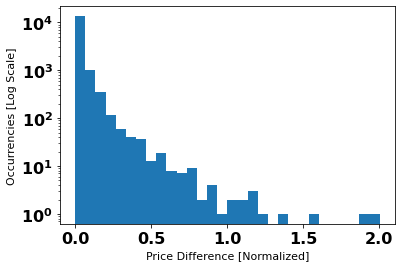

In [27]:
a = np.hstack(price_model.price_model)
plt.hist(a, bins=30)
plt.yscale('log')
plt.xlabel('Price Difference [Normalized]', fontsize=11)
plt.ylabel('Occurrencies [Log Scale]', fontsize=11)
plt.show()

In [28]:
def price_likely_matches(price, price_model, target_df):
    
    def calc_score(x):
        try:
            return price_model.price_likely_score(np.abs((price - x) / price))
        except:
            return 0
    
    target_match = target_df.copy()
    target_match['price_score'] = np.array(0)
    target_match['price_score'] = target_match['price']\
        .apply(lambda x: calc_score(x))
    return target_match

### Statistical goodness of fit test 
Is normalized price difference following an exponential distribution?

In [29]:
import scipy.stats as stats
#H0: price_model follows exponential distribution
#H1: price_model does not follow exponential distribution
hyp_test = stats.kstest(price_model.price_model, 'expon')
res = 'Price difference does ' + ('' if hyp_test[1] > 0.05 else 'not ') +\
        f'follow the exponential distribution, p-value: {hyp_test[1]}'
print(res)

Price difference does not follow the exponential distribution, p-value: 0.0


In [30]:
def calculate_match_score(zalando_offer_id, offer_df, target_df):
        
    zalando_offer = offer_df.loc[offer_df['offer_id'] == zalando_offer_id]

    z_b = zalando_offer['brand'].values[0]
    z_t = zalando_offer['title'].values[0]
    z_c = zalando_offer['color'].values[0]
    z_p = zalando_offer['price'].values[0]
        
    #filter target_df based on brand
    target_df = brand_likely_matches(z_b, brand_collection, target_df)
    #filter target_df based on title
    if len(target_df) > 0:
        target_df = title_likely_matches(z_t, bm25matcher_title, target_df)
    else:
        target_df['title_score'] = np.array(0)
        
    if len(target_df) > 0:
        target_df = color_likely_matches(z_c, bm25matcher_color, target_df)
    else:
        target_df['color_score'] = np.array(0)
    
    if len(target_df) > 0:
        target_df = price_likely_matches(z_p, price_model, target_df)
    else:
        target_df['price_score'] = np.array(0)
        
    return target_df[['offer_id', 'title_score', 'color_score', 'price_score']]

In [31]:
#calculate_match_score('dbf70606-78ba-4f93-93af-4b6ecdf15006', zalando_prod_training, aboutyou_prod_training)

## Train ANN to tune the feature weights
### Create labelled data

In [32]:
def create_labelled_data(sample_prop = 0.001, attr_to_compare='zalando', attr_to_find='aboutyou'):
    #Prepare labeled data for fitting
    fitting_examples = matches_training_df.sample(frac=sample_prop, random_state=19)
    zalando_fitting = zalando_prod_training.loc[
        zalando_prod_training['offer_id'].isin(fitting_examples[attr_to_compare])
    ]
    #aboutyou_fitting = aboutyou_prod_training.loc[
    #    aboutyou_prod_training['offer_id'].isin(fitting_examples['aboutyou'])
    #]
    match_score_df = pd.DataFrame(columns=['offer_to_compare', 'offer_found', 'title_score', 'color_score', 'price_score', 'is_match'])
    for z_id in fitting_examples[attr_to_compare]:
        matches = calculate_match_score(z_id, zalando_prod_training, aboutyou_prod_training)
        for index, a_matches in matches.iterrows():
            is_match = len(fitting_examples.loc[
                (fitting_examples[attr_to_compare] == z_id)
                &
                (fitting_examples[attr_to_find] == a_matches['offer_id'])
            ])
            row = {'offer_to_compare': z_id, 
                   'offer_found': a_matches['offer_id'], 
                   'title_score': a_matches['title_score'],
                   'color_score': a_matches['color_score'],
                   'price_score': a_matches['price_score'],
                   'is_match': is_match
                  }
            match_score_df = match_score_df.append(row, ignore_index=True)
        
    return match_score_df

### Extract relevant examples for training

In [33]:
def extract_training_examples(labelled_df, n_negative = 2):
    extract_df = pd.DataFrame()
    all_positive = labelled_df[labelled_df['is_match'] == 1]
    for index, el in all_positive.iterrows():
        not_matches = labelled_df[
            (labelled_df['is_match'] == 0) & (labelled_df['offer_to_compare'] == el['offer_to_compare'])
        ]
        not_matches = not_matches.sample(min(n_negative, len(not_matches)), replace=False)
        extract_df = extract_df.append(not_matches)
        extract_df = extract_df.append(el)
    return extract_df

### Save Labelled examples
Creates and saves a labelled training dataset for fitting the ANN

In [34]:
#Uncomment to create ANN training set using ground truth matches
#extract_training_examples(create_labelled_data(sample_prop=0.01), n_negative=1)\
#                    .to_parquet('data/label_data_training.parquet')

### Load labelled data

In [35]:
score_training_data = pd.read_parquet('data/label_data_training.parquet')
score_training_data

,offer_to_compare,offer_found,title_score,color_score,price_score,is_match
10,15230b72-2c20-4d7e-9f17-809c3c85eb0b,6cdadc63-056d-4aa9-8350-7095ee8a73b9,4.088910,5.530110,0.043315,0
0,15230b72-2c20-4d7e-9f17-809c3c85eb0b,ba00d767-ab41-4c64-9619-d99c623af1f7,17.754350,7.613899,0.317445,1
1247,3d96553f-2e24-48a6-b45f-d77afdbeda7b,6d175a97-4f93-40bb-b922-60b9673030ca,2.672670,1.087815,0.039689,0
143,3d96553f-2e24-48a6-b45f-d77afdbeda7b,e00fe5b6-a47c-44c4-868d-83896446f478,3.122388,3.705251,0.856145,1
1542,e0c40cb9-12cb-4948-bd30-2836d2995618,97b303da-f569-44e0-a325-651c737ae88b,2.522158,3.405175,0.000659,0
...,...,...,...,...,...,...
47890,113628df-0416-431d-916d-701601ac0b9e,9bca1ffd-4fa5-4f08-9976-298756f670ee,6.250012,8.070812,0.458004,1
48195,0381c947-9967-4a20-a361-416f3abb0e30,d3a672d8-2a6f-4e2b-8afa-b72fd04ea29f,1.555009,3.705251,0.005076,0
47917,0381c947-9967-4a20-a361-416f3abb0e30,dff14e9b-d328-4e40-8d5b-613a4e3c7d4f,12.867900,3.705251,0.470332,1
48626,b4c7a7ca-4c36-4dbc-9c1a-14c655e6bf82,d45f07f4-1dd8-43dd-9530-11c17567ac91,1.728434,5.530110,0.000000,0


### Test Training Model

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(
    score_training_data[['title_score', 'color_score', 'price_score']],
    score_training_data['is_match'],
    test_size=0.2
)
#X = score_training_data[['title_score', 'color_score', 'price_score']]
#y = score_training_data['is_match']
clf = MLPClassifier(solver='lbfgs', alpha=0.001,
                    hidden_layer_sizes=(5, 2), random_state=19)

clf.fit(X_train, y_train)
m_predicted = list(clf.predict(X_test))
m_actual = list(y_test)

### Evaluating the method

In [37]:
from sklearn.metrics import f1_score
print(f'f1 score for predicted samples = {f1_score(m_actual, m_predicted)}')

f1 score for predicted samples = 0.8936170212765958


### Fit ANN Model

In [38]:
from sklearn.neural_network import MLPRegressor
X = score_training_data[['title_score', 'color_score', 'price_score']]
y = score_training_data['is_match']
clf = MLPRegressor(solver='lbfgs', alpha=0.001,
                    hidden_layer_sizes=(5, 2), random_state=19)

clf.fit(X, y)

MLPRegressor(alpha=0.001, hidden_layer_sizes=(5, 2), random_state=19,
             solver='lbfgs')

In [39]:
class SimplePredictor:
    def predict(self, scores_df):
        return [el.sum() for idx, el in scores_df.iterrows()]
sp = SimplePredictor()

### Predict score on unseen data

In [40]:
def predict_match(offer_id, offer_df, target_df, predictor):
    scores = calculate_match_score(offer_id, offer_df, target_df)
    if len(scores) > 0:
        tot_score = predictor.predict(scores[['title_score', 'color_score', 'price_score']])
        scores['tot_score'] = tot_score
        scores['offer_compared'] = np.array(offer_id)
        scores = scores.sort_values(by='tot_score', ascending=False)[['offer_compared', 'offer_id']].head(1)
        return scores

In [41]:
def get_all_predictions(offers_to_compare, offers_to_search, predictor):
    predictions = [
        predict_match(id, offers_to_compare, offers_to_search, predictor) 
        for id in offers_to_compare['offer_id'].values
    ]
    prediction_df = pd.concat(predictions)
    prediction_df.columns = ['zalando', 'aboutyou']
    return prediction_df

In [42]:
calc_pred = False
start = time.time()
if calc_pred:
    all_predictions = get_all_predictions(zalando_prod_testing.sample(20000), aboutyou_prod_testing, sp)
#get_matches(list(matches_training_df['zalando'].values)[0])
end = time.time()
print('Computation time:', round(end-start, 4), 'sec')

Computation time: 0.0 sec


### Save predictions or load past predictions

In [43]:
if calc_pred:
    all_predictions.to_parquet('data/predictions_test_EXPn.parquet') #name the file 
else:
    all_predictions = pd.read_parquet('data/metrics/predictions_training_v1.parquet')

### Evaluate predictions (only on training matches)

In [44]:
get_metrics(
            matches_training_df.loc[:len(all_predictions)+1], 
            all_predictions, 
            aboutyou_prod_training 
           )

{'TP': 4699,
 'FN': 10471,
 'FP': 6041,
 'TN': 40769,
 'positives': 15170,
 'negatives': 46810,
 'precision': 0.43752327746741154,
 'recall': 0.3097560975609756,
 'F1': 0.3627170976456966}

### Explore predictions

In [45]:
#explore_match(all_predictions.iloc[0], matches_training_df)
#all_predictions.iloc[0]['zalando']

### Color Prediction (not possible to complete)

In [46]:
#p1 = get_palette_imgs(zalando_prod_training['image_urls'].values[0])
#p2 = get_palette_imgs(zalando_prod_training['image_urls'].values[1])

In [47]:
#palette_similarity(p1, p2)